# Search FORS2 galaxies in Simbad catalogs

In [1]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.coordinates as coordinates
from astropy.coordinates import angular_separation
#(lon1, lat1, lon2, lat2)
from astropy.coordinates import Angle
import astropy.units as u
import h5py
import pandas as pd
import numpy as np

In [2]:
def GetColumnHfData(hff,list_of_keys,nameval):
    """
    Extract hff atttribute 
    
    parameters
      hff           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
           the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=hff.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data


In [3]:
def ReadFors2h5FileAttributes(hf):
    hf =  h5py.File(input_file_h5, 'r') 
    list_of_keys = list(hf.keys())
    # pick one key    
    key_sel =  list_of_keys[0]
    # pick one group
    group = hf.get(key_sel)  
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)
    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, list_of_keys ,key)
        df_info[key] = arr
    df_info.sort_values(by="num", ascending=True,inplace=True)
    df_info_num = df_info["num"].values
    key_tags = [ f"SPEC{num}" for num in df_info_num ]
    df_info["name"] = key_tags
    
    #'Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'lines', 'num', 'ra', 'redshift',
    
    df_info = df_info[['num' ,'name', 'ra', 'dec', 'Rmag','redshift','lines','RT','RV','eRV','Nsp']]
    return df_info
    

## Read FORS2 catalog

In [4]:
input_file_h5  = '../data/FORS2spectra.hdf5'

In [5]:
hf =  h5py.File(input_file_h5, 'r') 
list_of_keys = list(hf.keys())

In [6]:
df_info = ReadFors2h5FileAttributes(hf)

In [7]:
df_info = df_info[['num', 'ra', 'dec', 'Rmag','redshift']]

In [8]:
df_info

,num,ra,dec,Rmag,redshift
51,2,13.52997,-28.44776,21.18,0.34555
112,3,13.52552,-28.42080,21.45,0.68660
545,9,13.50219,-28.40641,21.60,0.29266
17,13,13.49261,-28.38272,23.14,0.68870
43,19,13.60758,-28.43452,21.70,0.48395
...,...,...,...,...,...
531,734,13.68083,-28.23290,0.00,0.23012
532,735,13.69958,-28.23161,19.28,0.36169
533,736,13.66431,-28.22849,21.64,0.55777
534,737,13.62722,-28.22692,21.40,0.52001


## Simbad catalog

### find central cluster coordinates

In [9]:
target_name_simbad = "BAX 013.5117-28.3994"
target_name_ned = "RX J0054.0-2823"

In [10]:
result_table = Simbad.query_object(target_name_simbad)

In [11]:
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
BAX 013.5117-28.3994,00 54 02.8,-28 23 58,5,5,--,--,0,D,,1998ApJ...502..558V,1


In [12]:
ra_str = result_table['RA'][0] + ' hours'
dec_str = result_table['DEC'][0] + ' degree'

In [13]:
coord = coordinates.SkyCoord(ra_str,dec_str)
coord

<SkyCoord (ICRS): (ra, dec) in deg
    (13.51166667, -28.39944444)>

In [14]:
coord.ra.deg

13.511666666666665

In [15]:
coord.dec.deg

-28.399444444444445

In [16]:
# Simbad.list_votable_fields()

In [17]:
Simbad.add_votable_fields('z_value','rv_value','flux(U)','flux(B)', 'flux(V)', 'flux(R)', 'flux(I)',
                          'flux(J)','flux(H)','flux(K)','otype')

In [18]:
# Simbad.get_field_description ('z_value') 

In [19]:
# Simbad.get_field_description ('rv_value') 

In [20]:
# Simbad.get_field_description ('flux(filtername)') 

In [21]:
result_table = Simbad.query_region(target_name_simbad, radius=0.25 * u.deg)

In [22]:
result_ptable = result_table.to_pandas()
result_ptable.head()

,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,...,FLUX_U,FLUX_B,FLUX_V,FLUX_R,FLUX_I,FLUX_J,FLUX_H,FLUX_K,OTYPE,SCRIPT_NUMBER_ID
0,BAX 013.5117-28.3994,00 54 02.8,-28 23 58,5,5,NaN,NaN,0,D,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ClG,1
1,[GGM2011] 210,00 54 03.18,-28 24 00.7,6,6,NaN,NaN,0,D,O,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Galaxy,1
2,[GGM2011] 512,00 54 03.14,-28 23 52.7,6,6,NaN,NaN,0,D,O,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Galaxy,1
3,[GGM2011] 511,00 54 03.29,-28 24 10.8,6,6,NaN,NaN,0,D,O,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Galaxy,1
4,[GGM2011] 209,00 54 02.21,-28 23 45.4,6,6,NaN,NaN,0,D,O,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Galaxy,1


In [23]:
result_ptable.columns

Index(['MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA',
       'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH',
       'COO_BIBCODE', 'Z_VALUE', 'RV_VALUE', 'FLUX_U', 'FLUX_B', 'FLUX_V',
       'FLUX_R', 'FLUX_I', 'FLUX_J', 'FLUX_H', 'FLUX_K', 'OTYPE',
       'SCRIPT_NUMBER_ID'],
      dtype='object')

In [24]:
N = len(result_table)

In [25]:
all_ra = np.array([ Angle(result_table['RA'][idx] + ' hours').deg for idx in range(N) ])
all_dec = np.array([ Angle(result_table['DEC'][idx] + ' degrees').deg for idx in range(N) ])

In [26]:
catalog_simbad = SkyCoord(all_ra*u.degree,all_dec*u.degree)

https://docs.astropy.org/en/stable/coordinates/matchsep.html#astropy-coordinates-matching

In [27]:
all_idx = []  # index of the match
all_d2d = []  # distance in arcsec
all_d3d = []

for index, row in df_info.iterrows():
    c = coordinates.SkyCoord(row['ra']*u.degree, row['dec']*u.degree)
    idx, d2d, d3d = c.match_to_catalog_sky(catalog_simbad)
    all_idx.append(idx)
    all_d2d.append(Angle(d2d[0]).arcsec)
    all_d3d.append(d3d)
    #print(idx,Angle(d2d[0]).arcsec,d3d)
    


Text(0.5, 0, 'cross-match angle in arcsec')

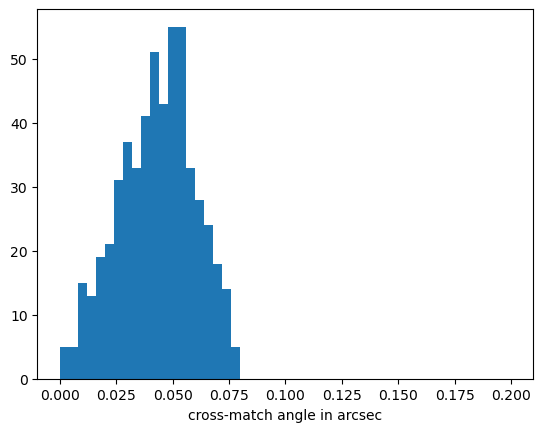

In [28]:
plt.hist(all_d2d,bins=50,range=(0,0.2));
plt.xlabel("cross-match angle in arcsec")

In [29]:
for index, row in df_info.iterrows():
    print("==================================================================================")
    print(key_tags[index], 'Z = ', row['redshift'])
    id_match = all_idx[index] 
    #print(result_table[id_match])
    print(result_table['MAIN_ID', 'Z_VALUE', 'FLUX_U', 'FLUX_B', 'FLUX_V',
       'FLUX_R', 'FLUX_I', 'FLUX_J', 'FLUX_H', 'FLUX_K', 'OTYPE'][id_match])

NameError: name 'key_tags' is not defined